Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [ ]:
using HDF5
using Serialization
using DataFrames, Plots

[ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0] (cache misses: wrong dep version loaded (2), incompatible header (2))
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: incompatible header (2))


In [28]:
# 1) read the raw byte‐blob from disk, automatically closing the file
blob = h5open("../all_timers_2.h5", "r") do f
    read(f, "all_timers")
end

# 2) deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
merged_timers = deserialize(IOBuffer(blob))

Dict{String, Dict{Int64, Dict{String, Any}}} with 3 entries:
  "1:1:1000"   => Dict(0=>Dict("total_time_ns"=>11501252, "total_allocated_byte…
  "10:1:1000"  => Dict(0=>Dict("total_time_ns"=>11376241, "total_allocated_byte…
  "100:1:1000" => Dict(0=>Dict("total_time_ns"=>11366434, "total_allocated_byte…

In [33]:
function timer_dict_to_df(timer_dict)
    rows = []

    for (trial, ranks) in timer_dict
        n_important_prt, total_rank, nprt_per_rank = split(trial, ":")
        trial_name = "$n_important_prt particles most weights"
        for (rank, timers) in ranks
            for (op, metrics) in timers["inner_timers"]
                for (metric, value) in metrics
                    if metric == "time_ns"
                        value = value / 1e6 # convert to milliseconds
                        metric = "time_ms"
                    end
                    push!(rows, (
                        trial  = String(trial_name),
                        total_rank = total_rank,
                        thread_per_rank = 1,
                        nprt_per_rank = nprt_per_rank,
                        rank   = rank,
                        op     = String(op),
                        metric = String(metric),
                        value  = value,
                    ))
                end
            end
        end
    end
    return DataFrame(rows)
end

# -- 2) Example: assume `timer_dict` is already in your workspace
df = timer_dict_to_df(merged_timers)
df_time = filter(row -> row.metric == "time_ms", df)
println(df_time)

12×8 DataFrame
 Row │ trial                       total_rank  thread_per_rank  nprt_per_rank  rank   op                 metric   value    
     │ String                      SubString…  Int64            SubString…     Int64  String             String   Any      
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1 particles most weights    1                         1  1000               0  write from buffer  time_ms  7.02201
   2 │ 1 particles most weights    1                         1  1000               0  receive loop       time_ms  4.43701
   3 │ 1 particles most weights    1                         1  1000               0  waitall            time_ms  0.002171
   4 │ 1 particles most weights    1                         1  1000               0  send loop          time_ms  0.040067
   5 │ 10 particles most weights   1                         1  1000               0  write from buffer  time_ms  6.55664
 

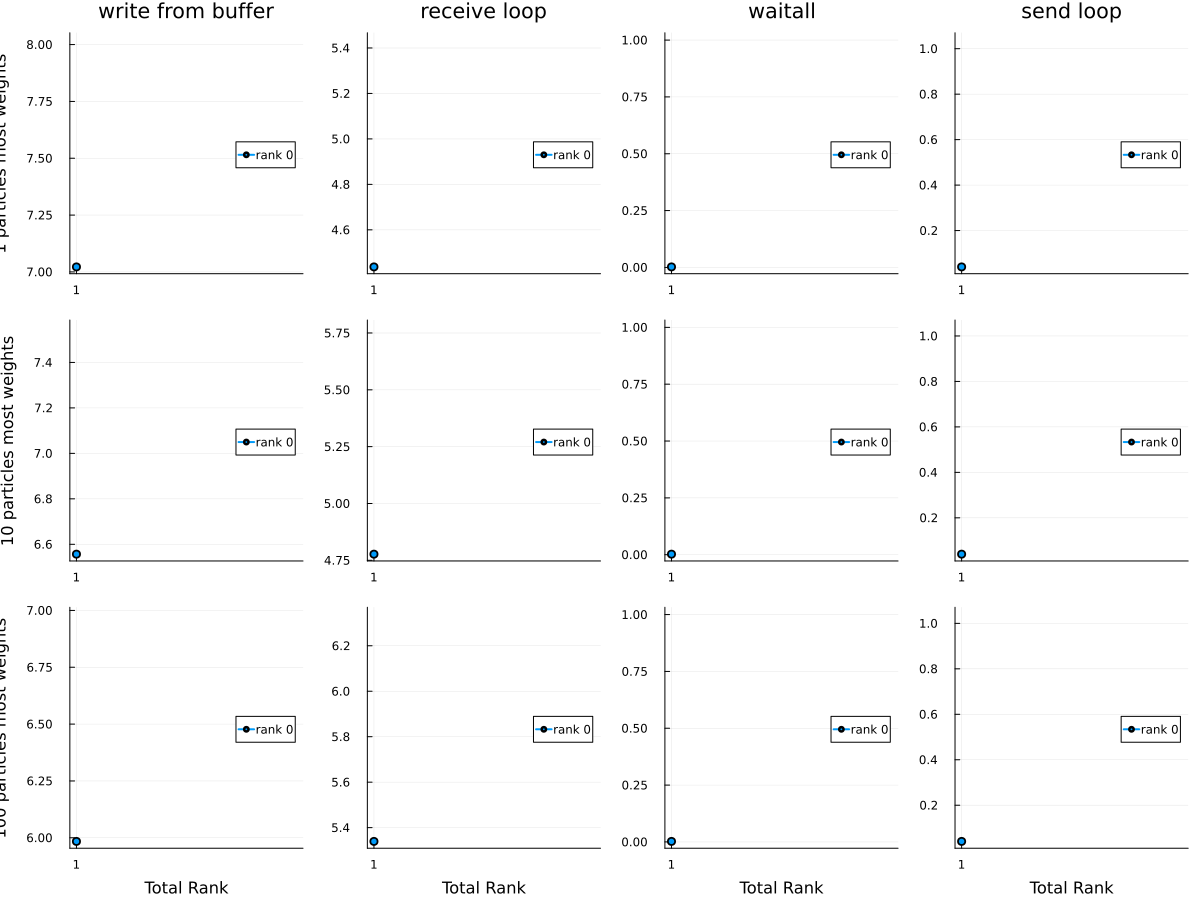

In [35]:
using DataFrames, Plots

# 1) Filter & rename to just the ms timings
df_ms = filter(row -> row.metric == "time_ms", df)
rename!(df_ms, :value => :time_ms)

trials = unique(df_ms.trial)
ops    = unique(df_ms.op)

ntrials, nops = length(trials), length(ops)

# 2) Create an empty grid
plt = plot(
  layout = (ntrials, nops),
  legend = :right,
  size   = (300 * nops, 300 * ntrials),
)

# 3) Fill it in
for (i, trial) in enumerate(trials)
  for (j, op) in enumerate(ops)
    sub = df_ms[(df_ms.trial .== trial) .& (df_ms.op .== op), :]

    # draw one line per rank
    for rk in unique(sub.rank)
      subrk = sub[sub.rank .== rk, :]
      plot!(
        plt[i, j],
        subrk.total_rank,
        subrk.time_ms;
        label  = "rank $rk",
        marker = :circle,
        lw     = 2,
      )
    end

    # 3a) Only the top row gets the op‐name as the title
    if i == 1
      plot!(plt[i, j], title = op)
    end

    # 3b) Only the first column gets its trial name as the y‐axis label
    #     All other columns get an empty y‐label so you only see the trial
    #     once per row.
    plot!(
      plt[i, j],
      ylabel = j == 1 ? trial : "",
    )

    # 3c) Only the bottom row gets the shared x‐axis label
    if i == ntrials
      plot!(plt[i, j], xlabel = "Total Rank")
    end
  end
end

display(plt)